## Build train and test data list

In [64]:
from __future__ import print_function
import keras
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.models import model_from_json
from keras import backend as K
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from skimage.feature import blob_log

import os
import glob
import numpy as np
import cv2
from collections import OrderedDict
import pickle

In [2]:
## read in all the augmented and noisy images
path = "./Multislice"
folders=os.listdir(path) 
data=[]    #all the images will be stored in this list.
defecttype=[]    #all the defect type corresponding to each image store in this list
defects={'Sw':0,'Mo':1,'W2s2':2,'Vw':3,'Vs2':4,'Ws':5}     # each int represents a defect type

for folder in folders:  #traversing all subfolders(types of defects) in MULTISLICE
    if '.' in folder:   #make sure it will not traverse file like '.DS_store'
        continue
    
    noisy_path = "./Multislice"+"/"+folder+'/'+folder+'_Augmented' 
    filelist = glob.glob(noisy_path+'/*.png')
    data.extend([img_to_array(load_img(fname, grayscale = True)) for fname in filelist])
    defecttype.extend([defects[folder]]*len(filelist))

In [130]:
## there should be 51125 images, each image with size of (64,64,1)
np.array(data).shape

(51125, 64, 64, 1)

In [3]:
#train test split

### We might want to try Suffle split to reduce bias in the test train split 
x_train, x_test, y_train, y_test = train_test_split(np.array(data), defecttype, test_size = 0.2, random_state = 28956)

## Train CNN

In [4]:
batch_size = 128
num_classes = 6
#epochs = 50

# input image dimensions
img_x, img_y = 64, 64
input_shape = (img_x, img_y, 1)

# Normalizing data
x_train = (x_train - np.amin(x_train))/(np.amax(x_train) - np.amin(x_train))
x_test = (x_test - np.amin(x_test))/(np.amax(x_test) - np.amin(x_test))

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [5]:
model = Sequential()

##### add layers to CNN model: 
model.add(Conv2D(16,kernel_size=(6,6),strides=(1,1),activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

#model.add(Conv2D(16,(5,5),activation='relu'))
#model.add(Conv2D(16,(3,3),activation='relu'))
#model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(32,(6,6),activation='relu'))
#model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(64,(6,6),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(num_classes,activation='softmax'))
######


model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.SGD(lr=0.01),
             metrics=['accuracy'])

In [16]:
model = Sequential()

##### add layers to CNN model: 
model.add(Conv2D(8,kernel_size=(7,7),strides=(1,1),activation='relu',input_shape=input_shape))
#model.add(Conv2D(8,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(16,(5,5),activation='relu'))
#model.add(Conv2D(16,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(32,(3,3),activation='relu'))
#model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(num_classes,activation='softmax'))
######


model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.SGD(lr=0.01),
             metrics=['accuracy'])

In [17]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self,logs={}):
        self.acc=[]
    
    def on_epoch_end(self,batch,logs={}):
        self.acc.append(logs.get('acc'))

epochs = 120

history=AccuracyHistory()
        
model.fit(x_train,y_train,
         batch_size=batch_size,
         epochs=epochs,
         verbose=1,
         validation_data=(x_test,y_test),
         callbacks=[history])

Train on 40900 samples, validate on 10225 samples
Epoch 1/120
40900/40900 [==============================] - 92s 2ms/step - loss: 1.7701 - acc: 0.2738 - val_loss: 1.7436 - val_acc: 0.2696
Epoch 2/120
40900/40900 [==============================] - 90s 2ms/step - loss: 1.5735 - acc: 0.3572 - val_loss: 1.4820 - val_acc: 0.3301
Epoch 3/120
40900/40900 [==============================] - 90s 2ms/step - loss: 0.9891 - acc: 0.5759 - val_loss: 0.7066 - val_acc: 0.7069
Epoch 4/120
40900/40900 [==============================] - 90s 2ms/step - loss: 0.6663 - acc: 0.7127 - val_loss: 0.5749 - val_acc: 0.7408
Epoch 5/120
40900/40900 [==============================] - 90s 2ms/step - loss: 0.5448 - acc: 0.7733 - val_loss: 0.5570 - val_acc: 0.8001
Epoch 6/120
40900/40900 [==============================] - 90s 2ms/step - loss: 0.4717 - acc: 0.8067 - val_loss: 0.4838 - val_acc: 0.8185
Epoch 7/120
40900/40900 [==============================] - 90s 2ms/step - loss: 0.4132 - acc: 0.8338 - val_loss: 0.3685 - 

40900/40900 [==============================] - 90s 2ms/step - loss: 0.0784 - acc: 0.9713 - val_loss: 0.2227 - val_acc: 0.9287
Epoch 60/120
40900/40900 [==============================] - 91s 2ms/step - loss: 0.0753 - acc: 0.9731 - val_loss: 0.1676 - val_acc: 0.9427
Epoch 61/120
40900/40900 [==============================] - 90s 2ms/step - loss: 0.0760 - acc: 0.9724 - val_loss: 0.1369 - val_acc: 0.9528
Epoch 62/120
40900/40900 [==============================] - 90s 2ms/step - loss: 0.0714 - acc: 0.9743 - val_loss: 0.1405 - val_acc: 0.9524
Epoch 63/120
40900/40900 [==============================] - 94s 2ms/step - loss: 0.0706 - acc: 0.9751 - val_loss: 0.1428 - val_acc: 0.9516
Epoch 64/120
40900/40900 [==============================] - 92s 2ms/step - loss: 0.0732 - acc: 0.9738 - val_loss: 0.1512 - val_acc: 0.9493
Epoch 65/120
40900/40900 [==============================] - 91s 2ms/step - loss: 0.0710 - acc: 0.9747 - val_loss: 0.1539 - val_acc: 0.9488
Epoch 66/120
40900/40900 [==============

Epoch 118/120
40900/40900 [==============================] - 89s 2ms/step - loss: 0.0213 - acc: 0.9937 - val_loss: 0.1666 - val_acc: 0.9558
Epoch 119/120
40900/40900 [==============================] - 89s 2ms/step - loss: 0.0209 - acc: 0.9940 - val_loss: 0.1740 - val_acc: 0.9550
Epoch 120/120
40900/40900 [==============================] - 89s 2ms/step - loss: 0.0203 - acc: 0.9937 - val_loss: 0.1770 - val_acc: 0.9542


In [24]:
#save the model
model.save("./New_5_8_18_defect_CNN.h5")
model.save_weights("./New_5_8_18_defect_CNN_weights.h5")


"""Or use this to save model"""

#model_json = model.to_json()
#with open("SJ_model.json", "w") as json_file:
#    json_file.write(model_json)
### serialize weights to HDF5
#model.save_weights("SJ_model.h5")

print("Saved model and weights to disk")

Saved model and weights to disk


In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 58, 58, 8)         400       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 29, 29, 8)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 25, 25, 16)        3216      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 10, 10, 32)        4640      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 3, 3, 64)          18496     
__________

## Class Activation Map

In [101]:
### Defining functions to use later ---

def image_preprocessing_cam(image_data, image_size):
    image_data = image_data.reshape(1, image_size[0], image_size[1], 1)
    image_data = image_data.astype('float32')
    image_data = (image_data - np.amin(image_data))/(np.amax(image_data) - np.amin(image_data))
    return image_data

def get_predictions(model, inputs):
    return model.predict(inputs)

def get_activation_maps(model, inputs, layer_num, learning_phase=0):
    get_layer_output = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer_num].output])
    layer_out = get_layer_output([inputs, learning_phase])[0]
    layer_out = layer_out[0, :, :, :]
    layer_out = np.transpose(layer_out,(2, 0, 1))
    return layer_out

def get_SoftmaxWeights(model):
    return model.layers[-1].get_weights()[0]

def get_defects(defects, n = target_class):
    
    for i, key in enumerate(defects.keys()):
        if i == n:
            return key

"""Load CNN Model here"""
#model = load_model('New_defect_CNN.h5')

model = model

#no. of the last conv layer(can be found in model.summary() )
last_conv_layer = -4

image_size = 64, 64

"""Load image file name here"""
image_file = 'SJ_gauss_Vw'

CAM_defects = {}

## Still working on this - incorporating coordinate search & making it better and well documented 
## but feel free to optimize
img = cv2.imread(image_file + '.png', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, image_size, interpolation = cv2.INTER_AREA)
img_i = np.copy(img)
img = image_preprocessing_cam(img, image_size) 
predictions = get_predictions(model, img)
target_class = predictions.argmax()
softmax_weights = get_SoftmaxWeights(model)
conv_out = get_activation_maps(model, img, last_conv_layer)

cam = np.zeros(shape = conv_out.shape[1:3], dtype = np.float32)

for idx, weight in enumerate(softmax_weights[:, target_class]):
    cam += weight * conv_out[idx, :, :]

cam = (cam - np.amin(cam))/(np.amax(cam) - np.amin(cam))
cam[np.where(cam < 0.5)] = 0
cam = cv2.resize(cam, image_size)

defect_class = get_defects(defects, target_class)

max_coord = blob_log(cam, min_sigma=0.8)
x, y = np.transpose(max_coord)[0:2,:]
coordinates = list(zip(x,y))

dictionary = OrderedDict()    
dictionary['Image'] = img_i
dictionary['Defect type'] = defect_class
dictionary['Defect coordinates'] = coordinates
dictionary['CAM'] = cam
CAM_defects[image_file] = dictionary

pickle.dump(CAM_defects, open("CAM_defects.pkl", "wb"))
#max_coord = blob_log(cam, min_sigma=0.5)
#x, y = np.transpose(max_coord)[0:2,:]
#coordinates = list(zip(x,y))

## Plotting Class activation map with image

defect type: Vw
defect coordinates (x, y): [(32.0, 30.0)]


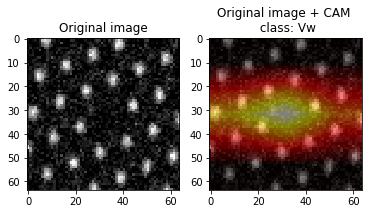

In [104]:
img, defect_type, defect_coordinates, cam = CAM_defects[image_file].values()
#img = cv2.imread(image_file + '.png', cv2.IMREAD_GRAYSCALE)
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img, cmap = 'gray')
ax1.set_title('Original image')
ax2.imshow(cam, cmap = 'hot')
ax2.imshow(img, cmap = 'gray', alpha = 0.5)
ax2.set_title('Original image + CAM \n class: ' + defect_type)

print('defect type:', defect_type)
print('defect coordinates (x, y):', str(defect_coordinates))

In [42]:
target_class

3

In [53]:
defects

{'Mo': 1, 'Sw': 0, 'Vs2': 4, 'Vw': 3, 'W2s2': 2, 'Ws': 5}

In [54]:
defects.values()

dict_values([0, 1, 2, 3, 4, 5])

In [52]:
defects.keys()

dict_keys(['Sw', 'Mo', 'W2s2', 'Vw', 'Vs2', 'Ws'])

In [58]:
def get_defects(defects, n = target_class):
    
    for i, key in enumerate(defects.keys()):
        if i == n:
            return key

In [59]:
get_defects(defects, target_class)

'Vw'

In [47]:
max_coord = blob_log(cam, min_sigma=0.8)
x, y = np.transpose(max_coord)[0:2,:]
coordinates = list(zip(x,y))
print(coordinates)

[(28.0, 29.0)]


## Other stuff that I was trying - gradient class activation map

In [172]:
from keras.preprocessing import image
from keras.layers.core import Lambda
from keras.models import Sequential
from tensorflow.python.framework import ops
import keras.backend as K
import tensorflow as tf
import numpy as np
import keras
import sys
import cv2

def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def load_image(img_path):
    
    img = image.load_img(img_path, grayscale = True, target_size=(64, 64))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    #x = preprocess_input(x)
    return x

def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)

def compile_saliency_function(model, activation_layer="conv2d_2"):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])

def modify_backprop(model, name):
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        new_model = VGG16(weights='imagenet') ##########################################################
    return new_model

def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def grad_cam(input_model, image, category_index, layer_name):
    model = Sequential()
    model.add(input_model)

    nb_classes = 6
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)
    model.add(Lambda(target_layer,
                     output_shape = target_category_loss_output_shape))

    loss = K.sum(model.layers[-1].output)
    conv_output =  [l for l in model.layers[0].layers if l.name is layer_name][0].output
    grads = normalize(K.gradients(loss, conv_output)[0])
    gradient_function = K.function([model.layers[0].input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam, (64, 64))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    #Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap

preprocessed_input = load_image('SJ.png')

model = model

predictions = model.predict(preprocessed_input)
#top_1 = decode_predictions(predictions)[0][0]
#print('Predicted class:')
#print('%s (%s) with probability %.2f' % (top_1[1], top_1[0], top_1[2]))

predicted_class = np.argmax(predictions)
cam, heatmap = grad_cam(model, preprocessed_input, predicted_class, "conv2d_36")
cv2.imwrite("gradcam.jpg", cam)

#register_gradient()
#guided_model = modify_backprop(model, 'GuidedBackProp')
#saliency_fn = compile_saliency_function(guided_model)
#saliency = saliency_fn([preprocessed_input, 0])
#gradcam = saliency[0] * heatmap[..., np.newaxis]
#cv2.imwrite("guided_gradcam.jpg", deprocess_image(gradcam))

IndexError: list index out of range

In [175]:
from keras.models import *
from keras.callbacks import *
import keras.backend as K


import cv2
import argparse

model_path = model 
img_path = "SJ.png"
output_path = "Trail_Image.png"

def visualize_class_activation_map(model_path, img_path, output_path):
        model = load_model(model_path)
        original_img = cv2.imread(img_path, 1)
        width, height, _ = original_img.shape

        #Reshape to the network input shape (3, w, h).
        img = np.array([np.transpose(np.float32(original_img), (2, 0, 1))])
        
        #Get the 512 input weights to the softmax.
        class_weights = model.layers[-1].get_weights()[0]
        final_conv_layer = model.get_layer("conv2d_36")
        #final_conv_layer = get_output_layer(model, "conv5_3")
        get_output = K.function([model.layers[0].input], [final_conv_layer.output, model.layers[-1].output])
        [conv_outputs, predictions] = get_output([img])
        conv_outputs = conv_outputs[0, :, :, :]

        #Create the class activation map.
        cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[1:3])
        for i, w in enumerate(class_weights[:, 1]):
                cam += w * conv_outputs[i, :, :]
        
        cam /= np.max(cam)
        cam = cv2.resize(cam, (height, width))
        heatmap = cv2.applyColorMap(np.uint8(cam), cv2.COLORMAP_JET)
        heatmap[np.where(cam < 0.2)] = 0
        img = heatmap*0.5 + original_img
        cv2.imwrite(output_path, img)

## Old Model

In [ ]:
model = Sequential()

##### add layers to CNN model: 
model.add(Conv2D(32,kernel_size=(5,5),strides=(1,1),
                activation='relu',
                input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(64,(5,5),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(1000,activation='relu'))
model.add(Dense(num_classes,activation='softmax'))
######


model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.SGD(lr=0.01),
             metrics=['accuracy'])

In [7]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self,logs={}):
        self.acc=[]
    
    def on_epoch_end(self,batch,logs={}):
        self.acc.append(logs.get('acc'))

history=AccuracyHistory()
        
model.fit(x_train,y_train,
         batch_size=batch_size,
         epochs=epochs,
         verbose=1,
         validation_data=(x_test,y_test),
         callbacks=[history])

Train on 40900 samples, validate on 10225 samples
Epoch 1/50
40900/40900 [==============================] - 283s 7ms/step - loss: 1.6054 - acc: 0.3772 - val_loss: 1.2119 - val_acc: 0.5668
Epoch 2/50
40900/40900 [==============================] - 279s 7ms/step - loss: 0.8499 - acc: 0.6784 - val_loss: 0.6669 - val_acc: 0.7566
Epoch 3/50
40900/40900 [==============================] - 273s 7ms/step - loss: 0.4930 - acc: 0.8068 - val_loss: 0.4115 - val_acc: 0.8365
Epoch 4/50
40900/40900 [==============================] - 271s 7ms/step - loss: 0.3457 - acc: 0.8667 - val_loss: 0.3731 - val_acc: 0.8498
Epoch 5/50
40900/40900 [==============================] - 273s 7ms/step - loss: 0.2912 - acc: 0.8860 - val_loss: 0.2777 - val_acc: 0.8920
Epoch 6/50
40900/40900 [==============================] - 273s 7ms/step - loss: 0.2624 - acc: 0.9003 - val_loss: 0.2308 - val_acc: 0.9099
Epoch 7/50
40900/40900 [==============================] - 272s 7ms/step - loss: 0.2321 - acc: 0.9101 - val_loss: 0.2453 - 